# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [2]:
# Import the visualization code
import visuals as vs
import numpy as np
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

- The smartcab does not move at all during the entire simulation. It remained idle. The smartcab's initial state was also not set, and thus, when the simulation was stopped and run again, the smartcab's starting location changes.
- The agent receives positive rewards when it remains idle, or when no action is taken at red light. It receives negative rewards or penalties when the traffic light is green, and there is no oncoming traffic. There is a higher weightage on the penalties, meaning when the car remained idle on green light rather than not making any traffic offences by remaining idle on red light.
- At red light, the cab should stop and remain idle to not make any traffic offences and avoid accidents. Since the car remained idle throughout, when there's red light, the smartcab receives positive rewards, in the typical range of 0.15 to 1.8. At green light, the cab is expected to move when there is no oncoming traffic. When the cab remained idle, the cab is probably causing more traffic, breaking traffic rule (which affects the Safety rating) and loses time on reaching its destination (affects the reliability rating). Hence, at green light, there is a heavier penalty typically in the range of -4.1 to -5.5. This means that red light increases the Smartcab's rating, and green light reduces the Smartcab's rating at current settings.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

`agent.py`

To alter the simulation, there are flags under `run()` function `agent.py`. Some of the flags that can be modified are:

- `num_dummies`: By changing the default value of 100, we can either increase or decrease the number of dummy agent drivers in the environment. This can affect the way our SmartCab agent operates in the environment, because lesser cars for example, reduces the chances of collision and therefore potentially reduces negative safety rating of the SmartCab
- `learning`: This is a Boolean value of either True or False and is used to allow the SmartCab agent to use Q-Learning learn from the current environment. Setting the value to True allows the SmartCab to learn
- `enforce_deadline`: This can be set to either True or False to set a deadline of timestep for the agent to reach its destination.

`environment.py`
- `act()` function is called when an agent performs an action

`simulator.py`
- `render_text()`: This is the non-GUI render display of the simulation. Simulated trial data will be rendered in the terminal/command prompt.
- `render()`: This is the GUI render display of the simulation. Supplementary trial data can be found from render_text.

`planner.py`
- `next_waypoint()` function checks for East-West direction first by checking on the shift in x (dx)

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


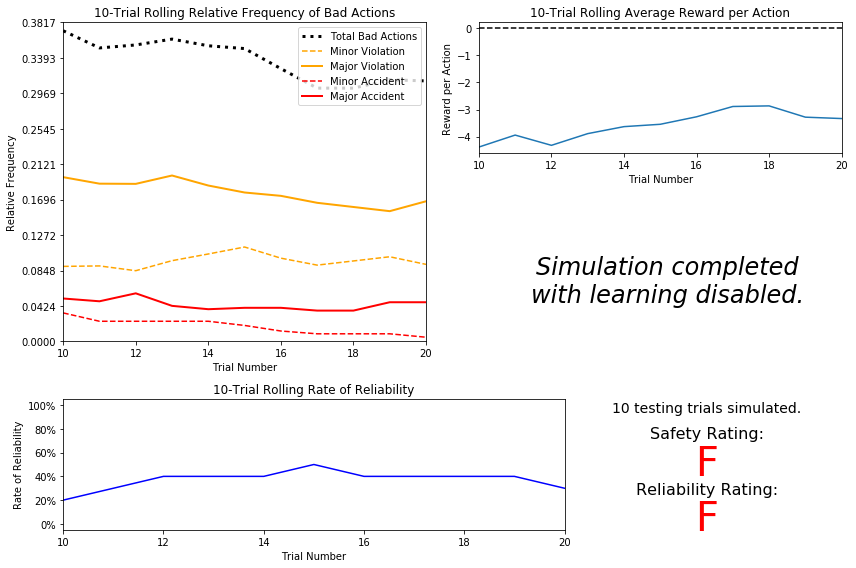

In [5]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

From the 'Bad Actions' visual above, the agent is making bad decisions for about 30-38% of the time. Since this number is taken by aggregating all bad behaviours, total good actions are about 62-70% of the time. 'Time' in this context is the rolling average of 10 previous trials for that current trial. So lets say for example, at trial number 12, the relative frequency is about 35% for bad behaviour (as taken from the graph above), this 35% is the average good behaviour within the deadline from trial number 2 - trial number 12. The actions available to the agent at any state is either to stay idle, move forward, turn left or turn right. While the violations are either one of these:

- Minor violation: Violation = 1. The traffic light is green and the agent remains idle. Reward += -5
- Minor accident:  Violation = 3. Running a red light to move right where there's an oncoming traffic from left, causing an accident. Reward += -20
- Major violation: Violation = 2. Running a red light and moving either left or forward. Reward += -10
- Major accident:  Violation = 4. Running a red light with major violation and causing an accident. Reward += -40

Referring to the 'Bad Actions' visual Total minor and major accidents contribute to about 10% of the total rolling frequency or about 33% of the total bad decisions. This means that, out of every 3 bad decisions the agent makes, there will be one accident.

Since the agent is driving randomly, it does not make sense for the reliability rate calculation, where it just checks for the number of successful trip completions before the end of given timesteps. Technically, the agent should be taught for correct driving methods, and it should be aware that everytime it reaches the destination, it will be getting positive rewards. Referring to the 'Reliability Rate' visuals, the rate of reliability typically varies from 20 - 40% or about 30% average. This number can be improved by training the agent to learn to adapt with rewards.

Good or negative rewards for good or bad behaviour as summarized below. The types of violations are explained above.
- Violation = 0. The agent took a valid action and gets a positive reward of either 1 (valid but incorrect action) or 2(valid and correct action) minus penalty (ranging from 0-1 as a function of time remaining)
- Violation = 1. The traffic light is green and the agent remains idle. Reward += -5
- Violation = 3. Running a red light to move right where there's an oncoming traffic from left, causing an accident. Reward += -20
- Violation = 2. Running a red light and moving either left or forward. Reward += -10
- Violation = 4. Running a red light with major violation and causing an accident. Reward += -40

The total rolling average rewards vary from -4 to -3 as can be seen from 'Rolling Average Reward per Action' visual above.

No real significant changes on the results since it is a random behaviour. This is supported by the visuals above. If there were more simulations conducted, this random behaviour, random rewards and random reliability will be plotted randomly as well. 

This smartcab is not safe and not reliable, as it's reliability rate is just about 20% and it is not a safe option. This is also shown as a rating of F for both reliability and safety.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

The Answer will be based on the US driving rules below:
### Environment
The *smartcab* operates in an ideal, grid-like city (similar to New York City), with roads going in the North-South and East-West directions. Other vehicles will certainly be present on the road, but there will be no pedestrians to be concerned with. At each intersection there is a traffic light that either allows traffic in the North-South direction or the East-West direction. U.S. Right-of-Way rules apply: 
- On a green light, a left turn is permitted if there is no oncoming traffic making a right turn or coming straight through the intersection.
- On a red light, a right turn is permitted if no oncoming traffic is approaching from your left through the intersection.
Reference: [drivers education video](https://www.youtube.com/watch?v=TW0Eq2Q-9Ac)

**Safety**
- The input data from env.sense function that returns traffic light state. As long as the agent follows traffic light state, it should be following valid actions. 
- traffic from left to make sure the action to turn right at red traffic light is not a bad option
- oncoming traffic to make sure it is clear for the agent to turn left if oncoming traffic is not turning right or moving forward

**Efficiency**
- The next waypoint data to decide on the next move. This is important as the agent knows how to efficiently move closer to the destination from every state and eventually reach the final destination.

***Not selected***
- right data is not really required as the traffic light data is present. As long as the agent follows the rules of the traffic lights, the rewards are the same.
- The deadline data on how much time is left to complete the journey (this can also be extracted from the penalty imposed as penalty is a function of time remaining). 

***Possible engineered-features***
- waypoint as a function of deadline so that both are incorporated as one.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

(`light, waypoint, left, oncoming`)

Total number of states = 2 x 4 x 4 x 4= 128

- There are 2 possible states for light =(green, red), 4 for waypoint = (None, forward, left, right), 4 for traffic from left = (None, forward, left, right) and 4 for oncoming traffic = (None, forward, left, right).

For the agent to learn all possible state-action, it has to have more than 128 x 4 = 512 time steps. Though both waypoint and deadline are actually functions of start and destination, waypoin is a good enough feature for the agent to learn to reach the destination.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

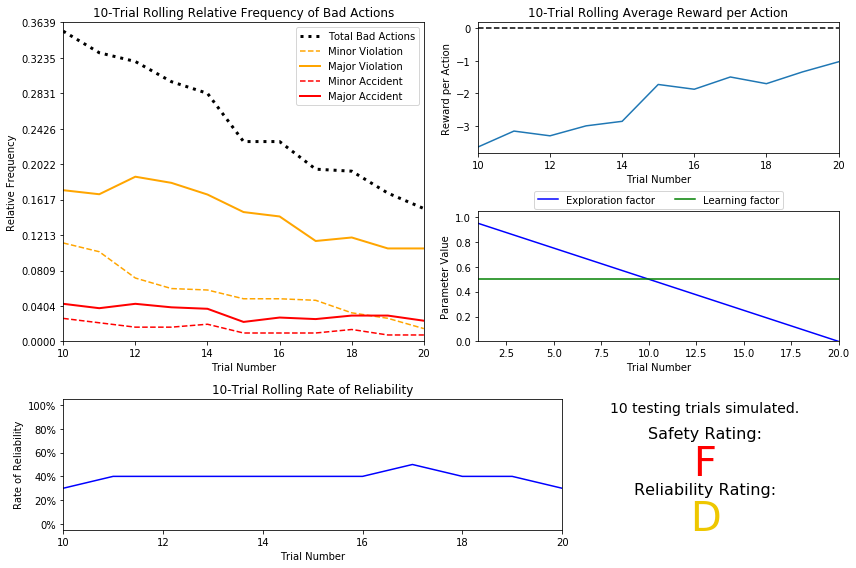

In [6]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

- The basic driving and default Q-learning driving agents both scored 'F' for Safety rating. The frequency of Bad Actions are still relatively high, although this frequency did reduce from 36% to 16% as the training trials increases. Reliability rate is improved slightly for this default-learning agent, with a 'D' rating compared to 'F' rating for basic agent that drives randomly. The reliability improves with time for default learning agent, with close to 40% from 10 - 20th training trial (rolling average). The average reward also improves over time, close to -1 in the end.
- 20 training trials required before beginning testing. As the starting epsilon (exploration factor) is 1 and it decays **linearly** by 0.05 per training trial, and the cut off tolerance for the exploration factor is 0.05, the number of trials required to go from 1 to 0.05 is 1/0.05 = 20 which confirms the training number given the initial epsilon, decay function and cut-off tolerance.
- The parameter panel shows the alpha value (learning factor), which is constant at 0.5 throughout and the exploration factor that decays linearly with time, 0.05 per time step. The blue curve shows this accurately
- The number of Bad actions decreased quite rapidly, from 36% to 16%. The average reward per action has also increased from -3 to $\approx -1.0$. This can be said as the agent was learning with time with the given exploration factor and exploration function. From the `sim_default-learning.txt` file, some of the Q-values are not updated for actions of different state. This is mainly due to the limited number of trials given the epsilon decay function and also the limited number of exploration vs exploitation that the agent chooses to perform as an action. It can be said, in this setting, the probability of the agent 'exploring' other options at a particular state is quite low over the time trials.
- Both basic driving and default Q-learning agents performed poorly in terms of Safety, with a score of F. This can be improved for Q-learning agent by changing the epsilon function to decay slower at a negative exponent rate so to allow exploration and updates on Q-values for actions. Reliability of default-learning agent is D, better than the basic driving agent. This also can be improved by increasing the training trials.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

#### To test the different decay functions and how it 'decays' with time

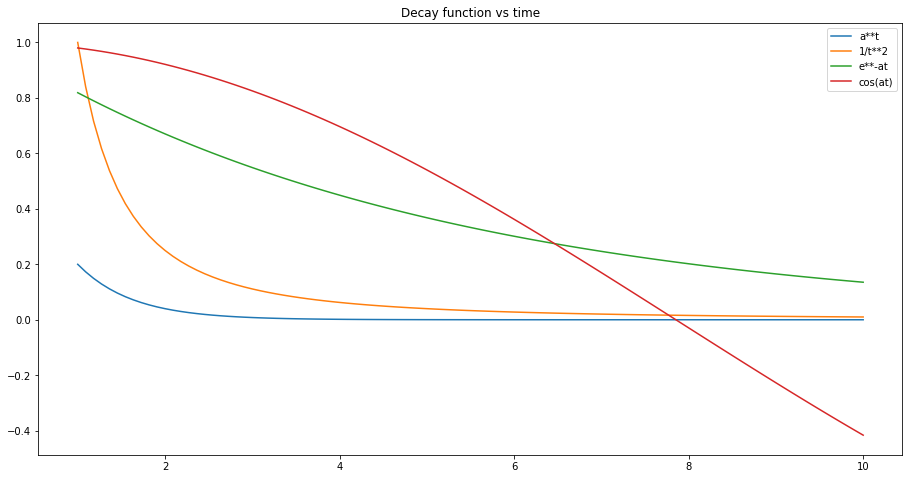

In [32]:
a = 0.2
time = np.linspace(1,10,100)

fig = plt.figure(figsize=(12,6))

ax = fig.add_axes([0,0,1,1])

ax.set_title('Decay function vs time')
ax.plot(time, a**time, label="a**t")
ax.plot(time, 1.0/time**2, label="1/t**2")
ax.plot(time, np.exp(-a*time),label="e**-at")
ax.plot(time, np.cos(a*time),label="cos(at)")
ax.legend()

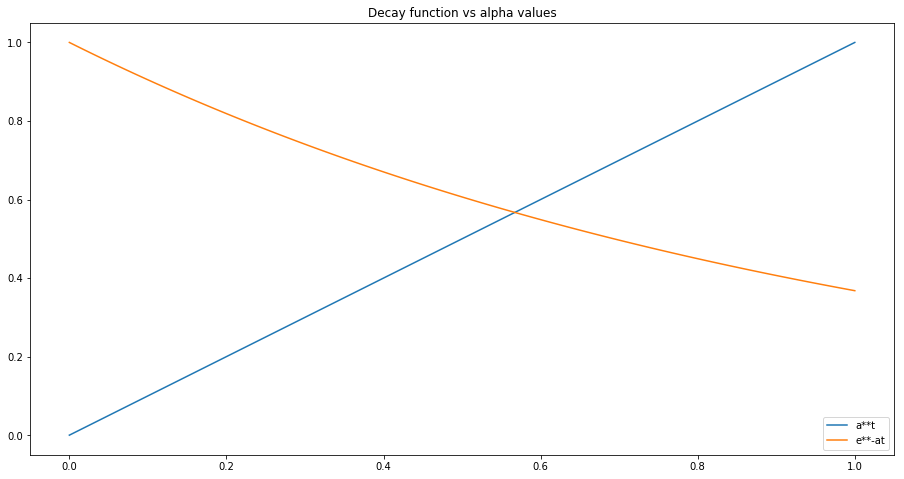

In [31]:
a = np.linspace(0,1,100)
time = 1

fig = plt.figure(figsize=(12,6))

ax = fig.add_axes([0,0,1,1])

ax.set_title('Decay function vs alpha values')


ax.plot(a, a**time, label="a**t")
ax.plot(a, np.exp(-a*time),label="e**-at")
ax.legend()

From visuals above, it can be seen that between 0 < alpha < 0.55, e^-at has the better decay function that takes the whole range of time into consideration of exploration rather than pure exploitation. At alpha > 0.55, a^t is a better option

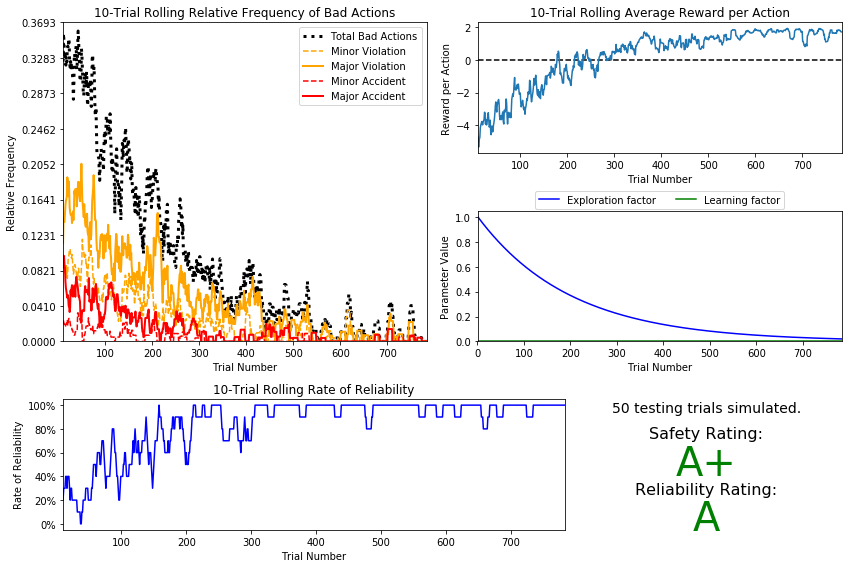

In [7]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

#### Settings used for this optimized learning:

learning rate, $\alpha = 0.005$ <br>
starting exploration factor, $\epsilon_{start} = 1$ <br>
tolerance, $\epsilon_{cut-off} = 0.02$ <br>
decay function, $\epsilon = e^{-at}$ <br>
- By comparing the visual aid above, it can be seen that between 0 < alpha < 0.55, $e^{-at}$ has the better decay function that takes the whole range of time into consideration of exploration rather than pure exploitation. Hence $\epsilon = e^{-at}$ is taken as the decay function.
- with $\alpha = 0.005$ and final $\epsilon = 0.02$, the time, or number of trials taken is $\ln 0.02 = -0.005t$, solving this gives $t\approx 782$ trials.
- learning rate, $\alpha = 0.005$ and tolerance, $\epsilon_{cut-off} = 0.02$ values were used. This is to give a higher number of trials and to train the agent better as explained in Question 5, more than 512 number of trials required to compensate for the state-action combinations. Of course, by having a higher number of trials, it allows the agent to update the Q-table in a more appropriate manner, by taking all possible actions at a state depending on the epsilon probability. So, as the learning rate is low, the agent's learning rate is quite low, and this causes the decay function to reduce at a less steeper rate, allowing the agent to explore more possible state-action-reward and possibility of updating the Q-table appropriately. This is confirmed in the sim_improved-learning.txt file where most states are updated with at least one Q-value.
- There are notable differences between this Optimized Q-Learning Agent and default Q-Learning Agent. Improvements made:
    - Safety rating improved from 'F' to 'A+'. This means that the Agent commits no traffic violations,and always chooses the correct action.
    - Reliability rating improved from 'D' to 'A'. This means that the Agent reaches the destination at least 90% of time.
    - From visuals of bad actions against time, the number of bad actions were reduced in a negative exponential order against time. This trend follows the decay function trend. In the end there are close to 0% bad action commited by the agent.
    - Reliability frequency also ranges between 90-100% from trial number $\approx 300$. This means that the agent has learnt to follow the waypoint and reach the destination before the deadline.
    - Number of rewards reaches positive after $\approx 300$ trials and this is consistent within 0-2.0 from then on. 
- The results obtained shows that the agent chooses the right option at any given state when it comes to **Safety**. Also for the **Reliability**, the agent chooses the right waypoint and reaches the destination 90% of the time. In relative to the basic driving agent and the default Q-Learning agent, it is safe to say that the Optimized Q-Learning agent has successfully learnt the right policy to map a state to the appropriate action.
- With a **Safety** rating of A+, the agent proves to be a very safe driver, hence this is beyond satisfactory. Safety of the Smartcab is of utmost concern because we want the smartcab to be safe and avoid accidents at all cost first, before taking the passengers to the destination, unlike the default-learning agent. As with the **Reliability** rating of A, The agent reaching the destination 90% of the time is also beyond satisfactory, close to most human drivers. And on top of that, the fact that some human drivers refusing to go to a particular destination for whatever the reason ([Uber Drivers Stiff Passengers after finding destination](https://www.nbcwashington.com/news/local/Uber-Drivers-Stiff-Passengers-After-Finding-Out-Final-Destination-408432315.html)), at least this smartcab beats that odd of not reaching the destination.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 
#### 1) Optimal Policy:

Since we want to train our agent to guide the smartcab to be a safe and reliable driver, we know that the smartcab has to reach the destination on time to be regarded as 'reliable' and follow all traffic rules at all times to be regarded as 'safe'. The optimal policy for the smartcab to be safe is by correctly following the traffic light rules, where as for it to be reliable, the optimal policy is for it to follow the next waypoint.

The optimal policies are shown in a Q-table, where in each state, all possible actions are given a value. The optimal policy is the one that maps a state to the action with highest value in the table. In summary, the policy should instruct the cab to act in following manner:
- Traffic light signals should always come as a priority ahead of the other features as mentioned in Question 4. If it is 'red' the agent should stop and then check for waypoint next. Only if the waypoint is 'right' then the agent should check for the next feature, traffic from left, and move right if there is no car from the left.
    - if traffic light == 'red' and next_waypoint not 'right' => action = None
    - if traffic light == 'red' and (next_waypoint == 'right' and traffic from left == 'forward') => action = None
    - if traffic light == 'red' and (next_waypoint == 'right' and traffic from left != 'forward') => action = Right
- If the traffic light signal is 'green' the agent is free to move forward and right. To move left, it has to check the oncoming traffic. Only when oncoming traffic is not moving forward or right, the agent is free to make that left turn, else the action is to stay idle and wait until the traffic is clear from oncoming direction. Nevertheless, the optimal policy should always guide the agent to check the waypoint next as described before. So, the second feature to check and follow after traffic light signals is waypoint. The agent should always follow the waypoint if the traffic light is 'green'
    - if traffic light == 'green' and next_waypoint not 'left'=> action = follow next_waypoint
    - if traffic light == 'green' and (next_waypoint == 'left' and (oncoming traffic == 'forward' or 'right')) => action = None
    - if traffic light == 'green' and (next_waypoint == 'left' and (oncoming traffic != 'forward' or 'right')) => action = right
- Third important feature to check for optimality is the traffic from left or oncoming, but this is only significant if the traffic light is 'red' and the waypoint is 'right' or if the traffic light is 'green' and the next waypoint is 'left'. Otherwise this is insignificant.
- The Q-value should be updated with the reward gained based on the priority explained above to meet the **Safety** rating first and then the **Reliability** rating.

#### 2) Check on log file

in `build_state()` of `LearningAgent` class:

`state = (waypoint, inputs['light'], inputs['left'], inputs[oncoming])`

By checking the sim_improved-learning.txt file, some example states are shown below:

**State 1**<br>
('left', 'green', 'forward', 'left')<br>
 -- None : -0.12<br>
 -- forward : -0.00<br>
 -- right : 0.01<br>
 -- **left : 0.38**<br>

**State 2** <br>
('right', 'green', 'forward', 'right')<br>
 -- None : 0.00<br>
 -- forward : -0.00<br>
 -- **right : 0.07**<br>
 -- left : 0.01<br>

**State 3**<br>
('left', 'red', 'right', 'left')<br>
 -- **None : 0.26**<br>
 -- forward : -0.20<br>
 -- right : 0.01<br>
 -- left : -0.25<br>
 
 **State 4**<br>
('right', 'green', 'right', 'forward')<br>
 -- None : -0.02<br>
 -- forward : 0.00<br>
 -- **right : 0.06**<br>
 -- left : 0.00<br>
 
 **State 5**<br>
('left', 'red', 'right', 'right')<br>
 -- **None : 0.06**<br>
 -- forward : 0.00<br>
 -- right : 0.00<br>
 -- left : 0.00<br>
 
**State 6** *Non Optimal*<br>
('forward', 'green', 'right', 'right')<br>
 -- None : -0.05<br>
 -- forward : 0.01<br>
 -- **right : 0.03**<br>
 -- left : 0.00<br>
 
**State 7**<br>
('right', 'green', 'forward', 'left')<br>
 -- None : -0.13<br>
 -- forward : 0.01<br>
 -- **right : 0.19**<br>
 -- left : 0.00<br>
 
In a whole, most states are updated appropriately to follow the optimal condition, meaning most of the time, the agent is mapped by the optimal policy from a state to the correct action. For example, all states above except State 6 are optimal. Actions with highest Q-value are bolded above. For example:
 - **State 1**: next waypoint is left, traffic light is green the expected action is to move left after making sure that the oncoming traffic is not moving right or forward, and 'left' is correctly captured as optimal with Q-value of 0.38
 - **State 2**: next waypoint is right and traffic light is green, so the expected action is to move right, and the optimal value is 'right' with 0.07 as value
 - **State 5**: next waypoint is left, traffic light is red, so the expected and optimal action is to stay idle. Action 'None' is correct with value of 0.06
<br>
<br>

**State 6** is non-optimal as shown above:
- **State 6**: next waypoint is forward, traffic light is green the expected and optimal action should be to move forward, but the action suggested is right.

as for State 6 where the agent makes a wrong move, the right action is positive Q-value and is slightly close to the wrong value (0.03 'right' vs 0.01 'forward'). In this case, the agent will avoid any sort of accident, and hence receives a positive reward. To make the agent take the correct waypoint at all times, there should be a heavier penalty for missing the correct waypoint if the path is clear and traffic light is green. For now, the penalty for missing the correct turning is small as a fraction of dealine.
 
 
 

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

Since discount factor takes the future rewards into consideration based on future state and action, the Q-value, $Q(s^{'},a^{'})$ is based on accurate prediction of future, or at least accurate state prediction. In fact, with the start and end points of the smartcab known, only the future waypoints can be accurately mapped. The main problems are hence associated with this future state predictions as summarized below:

**Environment**
- It is hard to predict future state of traffic lights, oncoming traffic, left traffic and right traffic.
- These states are random from the code block in `Environment` class. And it can change with time.
- Furthermore, from one trial to another, the states may differ with different start and end point for the smartcab and random positioning of the dummy agents and traffic light signals. So each future state prediction, if implemented, must be reset for each trial.
- The environment is random and not deterministic. By making choice about future based on future states and actions are only appropriate for deterministic environment. The locations, headings and states of dummy agents; the states of traffic lights are all **random** from one trial to another. With this in mind, using '`gamma`' factor to account for future rewards in not valid for this project as the states of future may change with time trials.
- The environment characteristic is therefore a **random state** at each trial

**Smartcab**
- Using future rewards to determine the current states value only makes sense if the agent knows what is the next best state to take from its current state, and the agent can compute this from the Q-value, only if the start and end points are the same at all time, meaning for all trials, the start location and destination is the same. But this is not the case, as for every trip (each trip is a time trial) the smartcab makes, the start and end point varies randomly. Again this is not deterministic, but random.
- The only next feature the agent can correctly anticipate at each trip is the waypoint (and even this changes for the next trip!)
- The start and endpoint of the smartcab changes with each trial and this is not constant. Thus, as previous explanation, the discount factor and future state predictions must be reset for each trial
- The smartcab charateristic is **random waypoint** at each trial

With more trials, the Q-value updated with the wrongly-predicted future state values would give out negative effects to the agent's ability to learn and could possibly cause the agent to not learn at all.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.